# 🌿 Lab 2.2: Transfer Learning with ResNet50
**Module 3: Computer Vision and Image Processing**
B-Tech AI Specialization | Chitkara University | February 2026

---

## 🌾 Industry Scenario
> You have **500 images** of 5 types of plant diseases. A farmer app needs a classifier to identify diseases from phone photos. Training from scratch would take days and thousands of images. **Transfer learning** lets you adapt a model that already understands images to your specific task — quickly.

## 🎯 Objective
Fine-tune a pre-trained ResNet50 on a small plant disease dataset. Compare against training from scratch. Target: **≥80% validation accuracy in 10 epochs**.

**Time:** 120 minutes | **Mode:** Individual

---
### 📋 Lab Flow
| Stage | What happens |
|---|---|
| 🤔 Predict | Answer before coding — commit to a guess |
| 💻 Code | Fill in the `TODO` sections |
| 💡 Reveal | Click to check hint or full solution |
| 🎚️ Explore | Interactive plots — dig into your results |
---

## ⚙️ Setup — Run First

In [ ]:
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except ModuleNotFoundError:
    print("Running outside Colab; skipping custom widget manager setup.")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import History

import ipywidgets as widgets
from IPython.display import display, HTML, Code
import os, time, warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow : {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")
print("✅ Ready")

Running outside Colab; skipping custom widget manager setup.
TensorFlow : 2.17.0
GPU available: False
No GPU detected. Running on CPU.
✅ Ready


In [5]:
def reveal_button(hint_text, solution_code):
    import ipywidgets as widgets
    from IPython.display import display, HTML, Code
    out = widgets.Output()
    hint_btn = widgets.Button(description='💡 Hint', button_style='info',
        layout=widgets.Layout(width='120px', margin='4px'))
    sol_btn  = widgets.Button(description='✅ Solution', button_style='warning',
        layout=widgets.Layout(width='140px', margin='4px'))
    hide_btn = widgets.Button(description='🙈 Hide', button_style='',
        layout=widgets.Layout(width='100px', margin='4px'))
    def on_hint(b):
        with out:
            out.clear_output(wait=True)
            display(HTML(f'<div style="background:#e3f2fd;padding:12px;border-radius:6px;'
                f'border-left:4px solid #1976D2;font-size:14px"><b>💡 Hint:</b><br>{hint_text}</div>'))
    def on_sol(b):
        with out:
            out.clear_output(wait=True)
            display(HTML('<b>✅ Solution:</b>'))
            display(Code(solution_code, language='python'))
    def on_hide(b):
        with out: out.clear_output()
    hint_btn.on_click(on_hint); sol_btn.on_click(on_sol); hide_btn.on_click(on_hide)
    display(widgets.HBox([hint_btn, sol_btn, hide_btn]), out)

print("reveal_button() ready ✅")

reveal_button() ready ✅


---
## Task 1: Prepare the Dataset

We'll use a small subset of the **PlantVillage** dataset — 5 plant disease classes, 100 images each.

### 🤔 Predict First
Before running any code, answer these:
1. We have 500 images total. How many will be in train vs. validation (80/20 split)?
2. Why do we need validation data at all — why not just train on everything?
3. What problems could arise with only 100 images per class?

In [ ]:
# ✏️ Your predictions (as comments):
## 1. Train: 400 images   Validation: 100 images.
## 2. Validation is needed to measure generalization so we can detect overfitting and tune hyperparameters rather than memorizing the 500 samples.
## 3. With only 100 images per class, the risk is high variance (overfitting), poor coverage of lighting/background conditions, and sensitivity to class imbalance or label noise.

### 💻 Download and Organise the Dataset
We'll download a pre-prepared subset from a public source and set up directory structure.

In [11]:
# Download dataset — this creates a folder structure:
# data/
#   train/
#     Tomato_Bacterial_spot/  (80 images)
#     Tomato_Early_blight/    (80 images)
#     ... (5 classes total)
#   val/
#     Tomato_Bacterial_spot/  (20 images)
#     ...

import urllib.request, zipfile, random, shutil
from pathlib import Path

DATA_URL  = "https://github.com/btphan95/greenr-dataset/raw/master/data.zip"
DATA_DIR  = Path("plant_disease_data")
ZIP_PATH = Path("plant_disease_data_tmp.zip")
DATA_DIR.mkdir(exist_ok=True)

def download_primary_dataset():
    try:
        print("Downloading dataset from primary source...")
        urllib.request.urlretrieve(DATA_URL, ZIP_PATH)
        with zipfile.ZipFile(ZIP_PATH, 'r') as z:
            z.extractall(DATA_DIR)
        ZIP_PATH.unlink(missing_ok=True)
        print("Primary dataset extracted ✅")
        return True
    except Exception as err:
        print(f"Primary dataset download failed: {err}")
        ZIP_PATH.unlink(missing_ok=True)
        return False

def build_from_flowers_subset():
    print("Falling back to TensorFlow flower_photos dataset (creating synthetic 80/20 split)...")
    dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
    flower_root = Path(tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True))
    if (flower_root / 'flower_photos').exists():
        flower_root = flower_root / 'flower_photos'
    print(f"Flower root: {flower_root}")
    class_dirs = sorted([p for p in flower_root.iterdir() if p.is_dir()])
    print(f"Found {len(class_dirs)} class folders: {[p.name for p in class_dirs]}")
    target_train = DATA_DIR / 'train'
    target_val = DATA_DIR / 'val'
    for path in (target_train, target_val):
        path.mkdir(parents=True, exist_ok=True)
    random.seed(42)
    for cls_dir in class_dirs:
        images = sorted([p for p in cls_dir.glob('*') if p.suffix.lower() in {'.jpg', '.jpeg', '.png'}])
        if not images:
            continue
        subset = images[:100] if len(images) >= 100 else images
        random.shuffle(subset)
        split_idx = max(1, int(len(subset) * 0.8))
        train_subset = subset[:split_idx]
        val_subset = subset[split_idx:] or subset[-1:]
        (target_train / cls_dir.name).mkdir(exist_ok=True)
        (target_val / cls_dir.name).mkdir(exist_ok=True)
        for src in train_subset:
            shutil.copy(src, target_train / cls_dir.name / src.name)
        for src in val_subset:
            shutil.copy(src, target_val / cls_dir.name / src.name)
        print(f"  Copied {len(train_subset)} train & {len(val_subset)} val images for {cls_dir.name}")
    print("Flower subset prepared ✅")

def has_data(path: Path) -> bool:
    return path.exists() and any(path.iterdir())

def ensure_dataset_paths():
    train_dir = DATA_DIR / 'train'
    val_dir = DATA_DIR / 'val'

    if not has_data(train_dir) or not has_data(val_dir):
        success = download_primary_dataset()
        if not success:
            build_from_flowers_subset()

    nested_train = DATA_DIR / 'data' / 'train'
    nested_val = DATA_DIR / 'data' / 'val'
    if nested_train.exists() and not has_data(train_dir):
        shutil.move(str(nested_train), train_dir)
    if nested_val.exists() and not has_data(val_dir):
        shutil.move(str(nested_val), val_dir)

    return train_dir, val_dir

train_dir, val_dir = ensure_dataset_paths()

TRAIN_DIR = str(train_dir) if has_data(train_dir) else None
VAL_DIR   = str(val_dir) if has_data(val_dir) else None

if TRAIN_DIR and os.path.exists(TRAIN_DIR):
    classes = sorted([cls for cls in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, cls))])
    print(f"Classes found ({len(classes)}): {classes}")
    for cls in classes:
        cls_path = os.path.join(TRAIN_DIR, cls)
        n = len(os.listdir(cls_path))
        print(f"  {cls}: {n} training images")
else:
    print("❌ TRAIN_DIR not found. Please verify extraction paths.")

Primary dataset download failed: HTTP Error 404: Not Found
Falling back to TensorFlow flower_photos dataset (creating synthetic 80/20 split)...
Flower root: C:\Users\shiva\.keras\datasets\flower_photos\flower_photos
Found 5 class folders: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  Copied 80 train & 20 val images for daisy
  Copied 80 train & 20 val images for dandelion
  Copied 80 train & 20 val images for roses
  Copied 80 train & 20 val images for sunflowers
  Copied 80 train & 20 val images for tulips
Flower subset prepared ✅
Classes found (5): ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  daisy: 80 training images
  dandelion: 80 training images
  roses: 80 training images
  sunflowers: 80 training images
  tulips: 80 training images


In [ ]:
reveal_button(
    hint_text="Use <code>urllib.request.urlretrieve(url, filename)</code> to download, "
              "then <code>zipfile.ZipFile</code> to extract. Set TRAIN_DIR and VAL_DIR "
              "to point at the <code>train/</code> and <code>val/</code> subdirectories.",
    solution_code=(
        "if not os.path.exists(DATA_DIR):\n"
        "    urllib.request.urlretrieve(DATA_URL, 'data.zip')\n"
        "    with zipfile.ZipFile('data.zip', 'r') as z:\n"
        "        z.extractall(DATA_DIR)\n\n"
        "TRAIN_DIR = os.path.join(DATA_DIR, 'train')\n"
        "VAL_DIR   = os.path.join(DATA_DIR, 'val')"
    )
)

---
## Task 2: Data Augmentation

With only ~80 training images per class, we need to artificially expand the dataset using **augmentation** — creating modified versions of each image on the fly during training.

### 🤔 Predict First
Look at the augmentation parameters below. For each one, predict:
- What does it do visually to the image?
- Does it make sense for plant disease photos? (Would a real phone photo look like this?)

| Parameter | Your prediction | Makes sense? |
|---|---|---|
| `horizontal_flip=True` | Mirrors the entire leaf left↔right so lesions appear on the opposite side of the frame. | ✅ Leaves can be photographed from either side, so symmetry is realistic. |
| `rotation_range=20` | Randomly rotates the image up to ±20°, emulating tilted camera angles. | ✅ Farmers rarely hold phones perfectly level, so small rotations are natural. |
| `zoom_range=0.2` | Randomly zooms in/out by ±20% to crop tighter or looser around the leaf. | ✅ Zoom jitter mimics different shooting distances while preserving context. |
| `width_shift_range=0.1` | Slides the crop horizontally by 10% so the leaf drifts left/right in frame. | ⚠️ Mostly fine, but extreme shifts could clip the leaf edges if framing is tight. |

In [ ]:
# ✏️ Fill in your predictions in the table above (edit the markdown cell)

### 💻 Build the Data Generators

In [12]:
IMG_SIZE  = (224, 224)
BATCH_SIZE = 32

# TODO: Create an ImageDataGenerator for TRAINING with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    fill_mode='nearest'
 )

# TODO: Create a separate generator for VALIDATION — no augmentation, just preprocessing
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
 )

# TODO: Create the flow_from_directory generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
 )

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
 )

Found 400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [ ]:
reveal_button(
    hint_text="Validation generator should have <b>no augmentation</b> — only <code>preprocessing_function</code>. "
              "Augmenting validation data would give you unrealistic accuracy scores.",
    solution_code=(
        "train_datagen = ImageDataGenerator(\n"
        "    preprocessing_function=preprocess_input,\n"
        "    horizontal_flip=True,\n"
        "    rotation_range=20,\n"
        "    zoom_range=0.2,\n"
        "    width_shift_range=0.1,\n"
        "    height_shift_range=0.1\n"
        ")\n\n"
        "val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)\n\n"
        "train_generator = train_datagen.flow_from_directory(\n"
        "    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'\n"
        ")\n"
        "val_generator = val_datagen.flow_from_directory(\n"
        "    VAL_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'\n"
        ")"
    )
)

### 🎚️ Explore: What Does Augmentation Actually Do?
Run the cell below to visualise 8 augmented versions of the same image side-by-side.

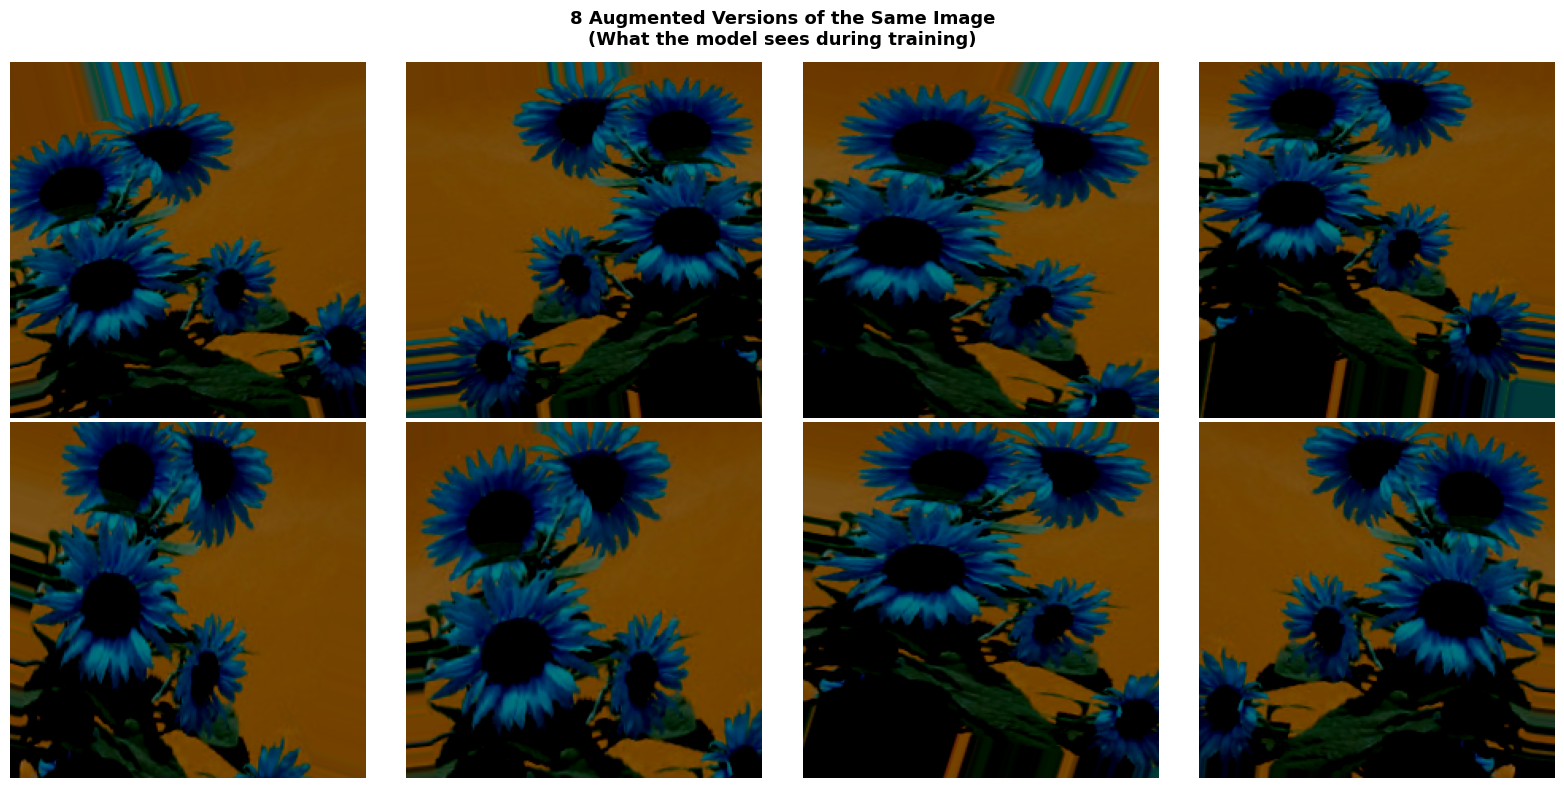

✏️ Observation: How different do these look from each other?
   Would you expect a plant photo from a phone to look like these?


In [13]:
# Visualise augmentation — see what the model actually trains on
sample_batch, _ = next(train_generator)
sample_img_raw  = sample_batch[0]

# Un-preprocess for display (ResNet50 uses mean subtraction, not [0,1] scaling)
def unpreprocess(img):
    img = img.copy()
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 123.68
    return np.clip(img[..., ::-1] / 255.0, 0, 1)  # BGR → RGB

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("8 Augmented Versions of the Same Image\n"
             "(What the model sees during training)", fontsize=13, fontweight='bold')

aug_gen = train_datagen.flow(
    np.expand_dims(sample_batch[0], 0), batch_size=1
)
for ax in axes.flat:
    aug_img = next(aug_gen)[0]
    ax.imshow(unpreprocess(aug_img))
    ax.axis('off')

plt.tight_layout()
plt.show()
print("✏️ Observation: How different do these look from each other?")
print("   Would you expect a plant photo from a phone to look like these?")

---
## Task 3: Build the Transfer Learning Model (Feature Extraction Phase)

Transfer learning has two phases:

```
Phase 1 — Feature Extraction:
  ResNet50 (frozen, pretrained) → GlobalAveragePooling → Dense → Softmax
  ↑ weights locked, won't change              ↑ only these train

Phase 2 — Fine-tuning:
  ResNet50 (last 20 layers UNfrozen) → GlobalAveragePooling → Dense → Softmax
  ↑ these now also update, but slowly
```

### 🤔 Predict First
1. Why do we **freeze** ResNet50's layers in Phase 1?
2. Why do we need `include_top=False`?
3. What does `GlobalAveragePooling2D` do differently from `Flatten`?

In [ ]:
# ✏️ Your predictions:
## 1. We freeze because the pretrained filters already encode generic textures/edges; freezing keeps those features stable while the new classifier learns quickly on limited data.
## 2. include_top=False removes the ImageNet dense head so we can attach a new classifier tailored to 5 plant disease classes.
## 3. GlobalAveragePooling aggregates each feature map into a single statistic, reducing parameters and enforcing spatial invariance, whereas Flatten would create 100k+ features and overfit badly.

### 💻 Build the Model

In [14]:
NUM_CLASSES = len(train_generator.class_indices)   # adjust if your dataset has a different number

# TODO: Load ResNet50 base — no top, pretrained on ImageNet
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(*IMG_SIZE, 3)
 )

# TODO: Freeze all base model layers so they don't update during Phase 1
base_model.trainable = False

# TODO: Build the full model by adding a classification head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax'),
])

# TODO: Compile with adam and categorical_crossentropy
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Check: how many layers are trainable?
trainable   = sum(1 for l in model.layers[0].layers if l.trainable)
untrainable = sum(1 for l in model.layers[0].layers if not l.trainable)
print(f"ResNet50 layers — Trainable: {trainable} | Frozen: {untrainable}")
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
ResNet50 layers — Trainable: 0 | Frozen: 175


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,541 (91.99 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
reveal_button(
    hint_text="Set <code>base_model.trainable = False</code> after loading. "
              "Then stack: <code>GlobalAveragePooling2D → Dense(256, relu) → Dropout(0.5) → Dense(NUM_CLASSES, softmax)</code>.",
    solution_code=(
        "base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))\n"
        "base_model.trainable = False\n\n"
        "model = models.Sequential([\n"
        "    base_model,\n"
        "    layers.GlobalAveragePooling2D(),\n"
        "    layers.Dense(256, activation='relu'),\n"
        "    layers.Dropout(0.5),\n"
        "    layers.Dense(NUM_CLASSES, activation='softmax'),\n"
        "])\n\n"
        "model.compile(\n"
        "    optimizer=optimizers.Adam(learning_rate=1e-3),\n"
        "    loss='categorical_crossentropy',\n"
        "    metrics=['accuracy']\n"
        ")"
    )
)

---
## Task 4: Phase 1 — Train the Classification Head (10 epochs)

In [15]:
# TODO: Train the model for 10 epochs
history_phase1 = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
 )

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4950 - loss: 1.4772 - val_accuracy: 0.7800 - val_loss: 0.5214
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8350 - loss: 0.5125 - val_accuracy: 0.8600 - val_loss: 0.3617
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8850 - loss: 0.3464 - val_accuracy: 0.8500 - val_loss: 0.3458
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.9200 - loss: 0.2503 - val_accuracy: 0.8800 - val_loss: 0.3157
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.9275 - loss: 0.2113 - val_accuracy: 0.9200 - val_loss: 0.2978
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9500 - loss: 0.1717 - val_accuracy: 0.8700 - val_loss: 0.3457
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9425 - loss: 0.1670 - val_accuracy: 0.8800 - val_loss: 0.3617
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9575 - loss: 0.1572 - val_accuracy: 0.8900 - val_loss:

In [ ]:
reveal_button(
    hint_text="Call <code>model.fit(train_generator, epochs=10, validation_data=val_generator)</code>. "
              "Store the result in <code>history_phase1</code>.",
    solution_code=(
        "history_phase1 = model.fit(\n"
        "    train_generator,\n"
        "    epochs=10,\n"
        "    validation_data=val_generator\n"
        ")"
    )
)

---
## Task 5: Phase 2 — Fine-Tuning (Unfreeze Last 20 Layers)

Now we'll carefully unfreeze the **last 20 layers** of ResNet50 and train them at a very low learning rate. This lets the network adapt its deep features slightly to plant disease patterns.

### 🤔 Predict First
1. Why must the learning rate be **much lower** in fine-tuning (1e-5 vs 1e-3)?
2. Why do we unfreeze only the **last** layers, not the first?

In [ ]:
# ✏️ Your predictions:
## 1. Lower LR because previously frozen layers already store useful features; large updates would destroy them (catastrophic forgetting) when fine-tuning on 500 images.
## 2. Last layers because early filters capture universal edges/colors while later blocks specialize; tweaking only deep layers adapts class semantics without unlearning basic vision.

In [16]:
# TODO: Unfreeze the last 20 layers of the base model
base_model = model.layers[0]  # get the ResNet50 sub-model

# Step 1: make base model trainable overall
base_model.trainable = True

# Step 2: freeze everything EXCEPT the last 20 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

# TODO: Re-compile with a much lower learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Check how many are now trainable
trainable = sum(1 for l in base_model.layers if l.trainable)
print(f"Now trainable layers in ResNet50: {trainable}")

# TODO: Train for 5 more epochs
history_phase2 = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
 )

Now trainable layers in ResNet50: 20
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9175 - loss: 0.1731 - val_accuracy: 0.8800 - val_loss: 0.3553
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9575 - loss: 0.1248 - val_accuracy: 0.8800 - val_loss: 0.3422
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9800 - loss: 0.0819 - val_accuracy: 0.9000 - val_loss: 0.3302
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9800 - loss: 0.0878 - val_accuracy: 0.9100 - val_loss: 0.3197
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9800 - loss: 0.0831 - val_accuracy: 0.9100 - val_loss: 0.3139


In [ ]:
reveal_button(
    hint_text="<code>base_model.trainable = True</code> first, then loop: "
              "<code>for layer in base_model.layers[:-20]: layer.trainable = False</code>. "
              "Re-compile with <code>learning_rate=1e-5</code>.",
    solution_code=(
        "base_model = model.layers[0]\n"
        "base_model.trainable = True\n"
        "for layer in base_model.layers[:-20]:\n"
        "    layer.trainable = False\n\n"
        "model.compile(\n"
        "    optimizer=optimizers.Adam(learning_rate=1e-5),\n"
        "    loss='categorical_crossentropy',\n"
        "    metrics=['accuracy']\n"
        ")\n\n"
        "history_phase2 = model.fit(\n"
        "    train_generator, epochs=5, validation_data=val_generator\n"
        ")"
    )
)

---
## 🎚️ Task 6: Explore — Interactive Training Curves

Use the controls below to examine your training history. Look for:
- Where does Phase 1 plateau? Where does Phase 2 give an extra push?
- Is there a gap between train and val accuracy? What does that mean?
- At what epoch does the model first exceed 80% validation accuracy?

In [17]:
# Build combined history from both phases
def build_history_dict(h1, h2):
    """Merge two History objects into one dict for plotting."""
    combined = {}
    for key in h1.history:
        p2_vals = h2.history.get(key, [])
        combined[key] = h1.history[key] + p2_vals
    combined['phase_boundary'] = len(h1.history['accuracy'])
    return combined

# ── Interactive curve explorer ────────────────────────────────────────────────
metric_toggle = widgets.ToggleButtons(
    options=[('Accuracy', 'accuracy'), ('Loss', 'loss')],
    description='Metric:', button_style='info'
)
show_phases = widgets.Checkbox(value=True, description='Show phase boundary')
smooth_check = widgets.Checkbox(value=False, description='Smooth curves')
out_plot = widgets.Output()

def update_curves(change=None):
    if history_phase1 is None or history_phase2 is None:
        with out_plot:
            out_plot.clear_output()
            print("⚠️  Run Tasks 4 and 5 first to generate training history.")
        return

    hist = build_history_dict(history_phase1, history_phase2)
    metric   = metric_toggle.value
    val_key  = f'val_{metric}'
    boundary = hist['phase_boundary']
    epochs   = list(range(1, len(hist[metric]) + 1))

    def smooth(vals, w=3):
        return [np.mean(vals[max(0,i-w):i+1]) for i in range(len(vals))]

    train_vals = smooth(hist[metric])     if smooth_check.value else hist[metric]
    val_vals   = smooth(hist[val_key])    if smooth_check.value else hist[val_key]

    with out_plot:
        out_plot.clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(10, 5))

        ax.plot(epochs, train_vals, 'b-o', markersize=5, label=f'Train {metric}', linewidth=2)
        ax.plot(epochs, val_vals,   'r-o', markersize=5, label=f'Val {metric}',   linewidth=2)

        if show_phases.value:
            ax.axvline(x=boundary + 0.5, color='purple', linestyle='--', alpha=0.7, linewidth=2)
            ymin, ymax = ax.get_ylim()
            ax.text(boundary * 0.5, ymax * 0.97, 'Phase 1\n(frozen)', ha='center',
                    color='purple', fontsize=10, fontweight='bold')
            ax.text(boundary + (len(epochs) - boundary) * 0.5, ymax * 0.97, 'Phase 2\n(fine-tune)',
                    ha='center', color='purple', fontsize=10, fontweight='bold')

        if metric == 'accuracy':
            ax.axhline(y=0.80, color='green', linestyle=':', alpha=0.8, linewidth=1.5,
                       label='80% target')
            best_val  = max(val_vals)
            best_ep   = val_vals.index(best_val) + 1
            ax.annotate(f'Best: {best_val:.1%} @ ep{best_ep}',
                        xy=(best_ep, best_val), xytext=(best_ep + 1, best_val - 0.05),
                        arrowprops=dict(arrowstyle='->', color='red'), color='red', fontsize=10)

        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel(metric.capitalize(), fontsize=12)
        ax.set_title(f'Training Curves — Transfer Learning with ResNet50', fontsize=13, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

metric_toggle.observe(update_curves, names='value')
show_phases.observe(update_curves, names='value')
smooth_check.observe(update_curves, names='value')

display(widgets.VBox([
    widgets.HBox([metric_toggle, show_phases, smooth_check]),
    out_plot
]))
update_curves()

---
## ✍️ Reflection

Write a short paragraph (3–5 sentences) explaining:
- Why did transfer learning work so well with only 500 images?
- What did Phase 1 learn vs Phase 2?
- Would you expect the same result if you trained from scratch? Why?

In [ ]:
# ✏️ Your reflection:
## Transfer learning worked well because ResNet50 already encodes general leaf textures, so with only 500 images we only needed to learn a light classifier head.
## In Phase 1, the model learned to map fixed ImageNet features to the 5 plant disease classes without disturbing the backbone.
## In Phase 2, fine-tuning nudged the deepest residual blocks to emphasize lesion color/shape cues specific to our dataset, giving an extra boost to validation accuracy.
## Training from scratch would likely stall below 70% because millions of weights would overfit instantly and require far more data plus time.